# Dynamic Pricing Model Using Hypothesis Testing

This notebook demonstrates how to dynamically optimize prices in an environment where only a limited number of price changes (experiments) is allowed.

### Use Case
We need to optimize the price for a single SKU without having any historical sales data for this SKU. However, we have some data for similar SKUs that allow us to roughly estimate the range of plausible price-demand functions. Our goal is to narrow down this range to a specific function with a minimum number of experiments (price changes). 

### Prototype: Approach and Data
We implement a dynamic price optimization model that generates a set of hypothesis (using historical data or some alternative approach) and optimizes price through ascent in this hypothesis space. The process rapidly converges as a functon of the number of price changes.

### Usage and Productization
This prototype is well-suited to productization in dynamic environments such as marketplaces. Productization would require to create a hypotheses generation process which is not included into the prototype.

### References
1. Cheung W., Simchi-Levi D., and Wang H. -- Dynamic Pricing and Demand Learning with Limited Price Experimentation, 2017

In [ ]:
#
# Imports and settings
#
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import functools
import matplotlib.animation as animation
import itertools

plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})
plt.rcParams.update({'pdf.fonttype': 'truetype', 'font.size': 18})

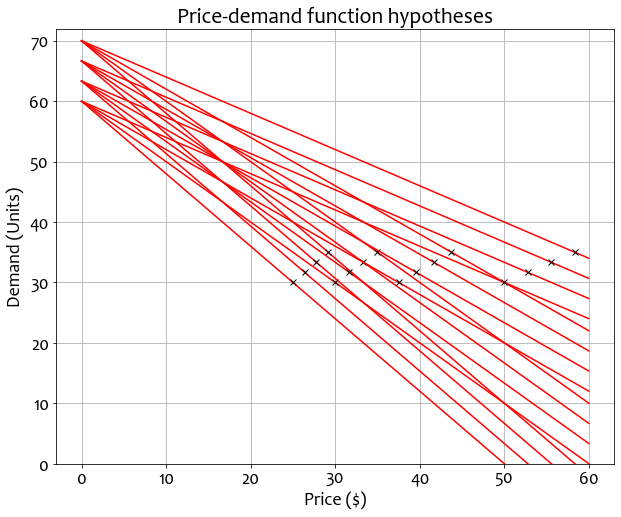

In [55]:
# Generate a set of hypothesis. We use linear demand functions 
# for the sake of illustration, although it is reasonable 
# choice for production as well
def linear(a, b, x):
    return b + a*x

# A linear demand function is generated for every 
# pair of coefficients in vectors a_vec and b_vec 
def demand_hypotheses(a_vec, b_vec):
    for a, b in itertools.product(a_vec, b_vec):
        yield {
            'd': functools.partial(linear, a, b),   # price-demand function
            'p_opt': -b/(2*a)                       # corresponding optimal price 
        }

start = -1.2
end = -0.6

# A list of demand function hypotheses and corresponding optimal prices
h_vec = list(demand_hypotheses(np.linspace(start, end, 4), np.linspace(60, 70, 4)))

prices = np.linspace(0, 60, 100)
fig = plt.figure(figsize=(10, 8))
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.ylim(0, 72)
plt.title('Price-demand function hypotheses')
plt.grid(True)
for d in h_vec:
    plt.plot(prices, list(map(d['d'], prices)), 'r-')
    plt.plot([d['p_opt']], d['d'](d['p_opt']), 'kx', linewidth=0.2)
plt.show()

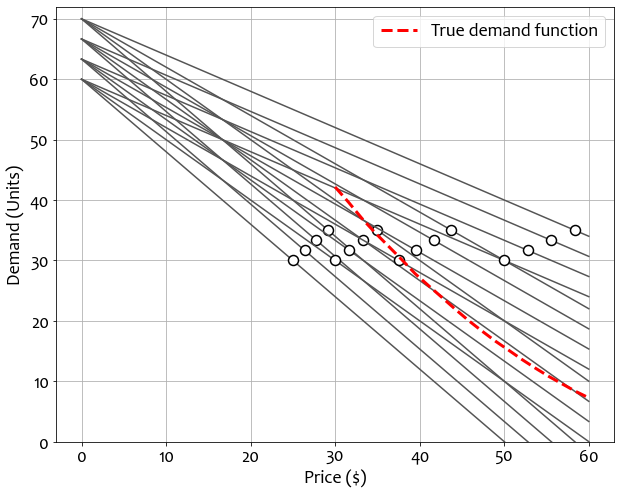

In [56]:
# Define and visualize empirical demand curve

def sample_actual_demand(price): 
    avg_demand = 65 + (-0.8) * price
    theta = 0.1/4
    k = avg_demand / theta
    return np.random.gamma(k*theta, k*theta**2, 1)[0]

def empirical_mean(sampler, n): 
    mean = 0 
    for i in range(1, n): 
        mean = mean + sampler() 
    return mean/n

def emperical_demand_curve(min_price, max_price, n): 
    prices = np.linspace(min_price, max_price, n) 
    sampling = 5000 
    demands = map(lambda p: empirical_mean(functools.partial(sample_actual_demand, p), sampling), prices) 
    return np.dstack((prices, list(demands)))[0]

curve = np.transpose(emperical_demand_curve(30, 60, 20))

fig = plt.figure(figsize=(10, 8))
for i, d in enumerate(h_vec):
    plt.plot(prices, list(map(d['d'], prices)), '-', color='#555555');
    plt.plot([d['p_opt']], d['d'](d['p_opt']), 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)
    
plt.plot(curve[0], curve[1], 'r--', linewidth=3.0, label='True demand function')
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.ylim(0, 72)
plt.grid(True)
plt.legend()

plt.show()

In [79]:
# Simulation of dynamic price optimization

def logx(x, n): 
    for i in range(0, n):
        x = math.log(x) if x>0 else 0
    return x

def rounds(m, T, scale):
    mask = []
    for i in range(1, m):
        mask.extend( np.full(scale * math.ceil(logx(T, m - i)), i-1) )
    return np.append(mask, np.full(T - len(mask), m-1))

T = 24 + 1  # time step is one hour, 10 days total 
m = 4       # not more than 4 price updates

tau = 0
d = h_vec[0]['d']
p = h_vec[0]['p_opt']

t_mask = rounds(m, T, 2)                      # generate the price change schedule in advance

history = []
for t in range(0, T-1):                       # simulation loop
    realized_d = sample_actual_demand(p)
    
    history.append([p, realized_d, d, p])
    
    if( t_mask[t] != t_mask[t + 1] ):         # it's time to re-optimize the price
        interval_demands = np.array(history)[tau : t + 1, 1]
        interval_avg_demand = np.mean(interval_demands)
        
        min_error = float("inf")
        for i, h in enumerate(h_vec):                      # look for a hypothesis that explains 
            error = abs(interval_avg_demand - h['d'](p))   # the observed data with a minimal error
            if(error < min_error):
                min_error = error
                h_opt = h
           
        p = h_opt['p_opt']                    # optimal price for the next price period 
        d = h_opt['d']
        tau = t+1  
        
history = np.array(history)

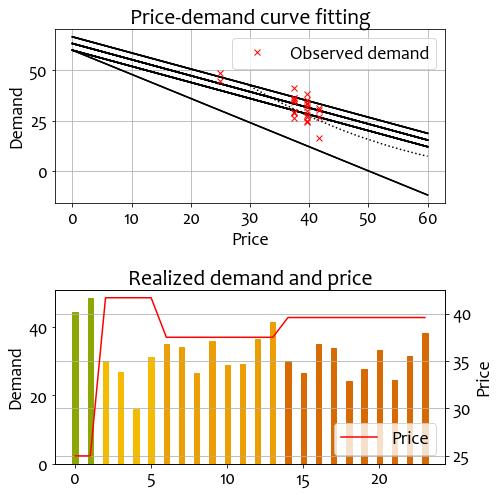

In [108]:
colors = ['#8EA604', '#F5BB00', '#EC9F05', '#D76A03']

def visualize_snapshot(t):
    fig.clear()
    
    plt.subplot(2, 1, 1)
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Price-demand curve fitting')
    plt.plot(curve[0], curve[1], 'k:') 
    plt.grid(True)
    for i in range(0, t):
        plt.plot(prices, list(map(history[i, 2], prices)), 'k-') 
    plt.plot(history[0:t+1, 0], history[0:t+1, 1], 'rx', label='Observed demand') 
    plt.legend()
    
    ax1 = plt.subplot(2, 1, 2)
    ax1.set_ylabel('Demand')
    bars = ax1.bar(range(0, T-1), np.pad(history[0:t+1, 1], (0, T-2-t), 'constant'), 0.35, label='Demand')
    for i in range(0, t+1):
        bars[i].set_color(colors[t_mask[i]])
    
    ax2 = ax1.twinx()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.set_title('Realized demand and price')
    ax2.plot(range(0, t+1), history[0:t+1,0], 'r-', label='Price') 
    ax2.grid(True)
    ax2.legend()
    
    plt.savefig('simulation-4.pdf')
    
fig = plt.figure(figsize=(7, 8))
plt.subplots_adjust(hspace=0.5)
visualize_snapshot(23)               # visualize the state in the end of the simulation
plt.show()

In [14]:
# Render and save the animation of the simulation process 

t = 0
def animate(f):
    global t
    visualize_snapshot(t)
    t = t + 1
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps = 10, bitrate = 2800)
    
fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-2, repeat=True)

ani.save('price_optimization_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)